<a href="https://colab.research.google.com/github/khangnkv/UniversityProjects/blob/main/des431_project2_MovieRecommendationSystem_LatentFactorModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** DES431 Project 2: Recommendation System **

# Background

**MovieLens** is a movie recommendation system operated by GroupLens, a research group at the University of Minnesota.

# Task

1. Propose and implement your own recommendation system based on the MovieLens dataset. Use `ratings_train.csv` as the training set, `ratings_valid.csv` as the validation set. Your system may use information from `movies.csv` and `tags.csv` to conduct recommendations. The undisclosed test set will be used to evaluate your system.
   - The data file structure is available at https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html.
   - The main goal of the recommendation system is to minimize the root-mean-square error.
   - The implementation should include a function named `predict_rating`. This function accepts a DataFrame with two columns `userId` and `movieId`. Then, the function adds a column named `rating` storing a predicted rating of a `movieId` by a `userId`.
   - Your program must return a root-mean-square error value when the validation set is changed to another file. Otherwise, your score will be deducted by 50%.
   - You must modify the given program to make better recommendations. Submitting the original program without modification is considered plagiarism.
2. Prepare slides for a 7-minute presentation to explain your proposed technique and algorithm to conduct recommendation, and show your RMSE results on the validation set.
3. Submit all required documents by April 30, 2023; 23:59. Late submission will not be accepted and will be marked 0. Do not wait until the last minute. Plagiarism and code duplication will be checked.
4. Present your work on May 1, 2023 within 7 minutes. Exceeding 7 minutes will be subject to point deduction.

In [66]:
# import package
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Loading data

In [68]:
ratings_train = pd.read_csv('/content/drive/MyDrive/Project 2/ratings_train.csv')
ratings_valid = pd.read_csv('/content/drive/MyDrive/Project 2/ratings_valid.csv')
movies = pd.read_csv('/content/drive/MyDrive/Project 2/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [69]:
print(ratings_valid)

      userId  movieId  rating   timestamp
0          4       45     3.0   986935047
1          4       52     3.0   964622786
2          4       58     3.0   964538444
3          4      222     1.0   945629040
4          4      247     3.0   986848894
...      ...      ...     ...         ...
2349     561   139385     3.5  1491092337
2350     561   146656     3.5  1491095479
2351     561   149406     3.5  1491091520
2352     561   160438     2.0  1491091498
2353     561   166528     4.0  1491095045

[2354 rows x 4 columns]


In [70]:
movies['movieId'] = movies['movieId'].astype('str')
print(movies)

     movieId                                      title  \
0          1                           Toy Story (1995)   
1          2                             Jumanji (1995)   
2          3                    Grumpier Old Men (1995)   
3          4                   Waiting to Exhale (1995)   
4          5         Father of the Bride Part II (1995)   
...      ...                                        ...   
9737  193581  Black Butler: Book of the Atlantic (2017)   
9738  193583               No Game No Life: Zero (2017)   
9739  193585                               Flint (2017)   
9740  193587        Bungo Stray Dogs: Dead Apple (2018)   
9741  193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                              

# Preprocessing Data

In [71]:
ratings_train.drop('timestamp',axis=1,inplace=True)
ratings_train['userId'] = ratings_train['userId'].astype('str')
ratings_train['movieId'] = ratings_train['movieId'].astype('str')
ratings_train

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
96459,610,166534,4.0
96460,610,168248,5.0
96461,610,168250,5.0
96462,610,168252,5.0


In [72]:
ratings_valid.drop('timestamp',axis=1,inplace=True)
ratings_valid['userId'] = ratings_train['userId'].astype('str')
ratings_valid['movieId'] = ratings_train['movieId'].astype('str')
ratings_valid

,userId,movieId,rating
0,1,1,3.0
1,1,3,3.0
2,1,6,3.0
3,1,47,1.0
4,1,50,3.0
...,...,...,...
2349,19,832,3.5
2350,19,837,3.5
2351,19,839,3.5
2352,19,842,2.0


# Generate Matrix and Predict Ratings

In [73]:
def generate_empty_movie_matrix(ratings):
    # Generate matrix
    matrix_df = ratings.pivot_table(index='userId', columns='movieId', values='rating')

    # Only keep popular movies (simplify the dataset)
    min_count = int(((100 - 65) / 100) * matrix_df.shape[0] + 1)
    matrix_df = matrix_df.dropna(axis=1, thresh=min_count)

    # Replace NaN values with 0s
    matrix_df.fillna(0, inplace=True)

    return matrix_df

In [74]:
matrix_df = generate_empty_movie_matrix(ratings_train)
matrix_df

movieId,1,110,2571,260,2959,296,318,356,480,527,589,593
userId,,,,,,,,,,,,
1,4.0,4.0,5.0,5.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0
10,0.0,0.0,0.5,0.0,0.5,1.0,0.0,3.5,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,3.5,0.0,4.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,5.0,4.0,5.0,3.0,0.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,3.5,0.0,4.0,0.0
96,5.0,5.0,4.0,5.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0
97,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [75]:
movies_list = list(matrix_df.columns)
movies_name_list = []
for item_id in movies_list:
    filtered_movies = movies.loc[movies['movieId'] == item_id, 'movieId'].values
    if filtered_movies.size > 0:
        movies_name = filtered_movies[0]
        movies_name_list.append(movies_name)
    else:
        movies_name_list.append(None)
matrix_df.set_axis(movies_name_list, axis=1, inplace=True)


# fill the NaN with 0
matrix = matrix_df.fillna(0).values

# look into the shape of matrix
display(matrix_df)

<ipython-input-75-4b73b1bb2e88>:10: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  matrix_df.set_axis(movies_name_list, axis=1, inplace=True)


,1,110,2571,260,2959,296,318,356,480,527,589,593
userId,,,,,,,,,,,,
1,4.0,4.0,5.0,5.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0
10,0.0,0.0,0.5,0.0,0.5,1.0,0.0,3.5,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,3.5,0.0,4.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,5.0,4.0,5.0,3.0,0.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,3.5,0.0,4.0,0.0
96,5.0,5.0,4.0,5.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0
97,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [76]:
# extract the non-zero index for matrix
## np.nonzero() = Return the indices of the elements that are non-zero.
users, items=matrix.nonzero()
m, n = matrix.shape

# set the hyperparameters
X_train=matrix

n_latent_features=4
# initialize P and Q
P = np.random.rand(m,n_latent_features)
Q = np.random.rand(n,n_latent_features)

In [77]:
# look into the shape of P and Q
print(P.shape)
print(Q.shape)

(610, 4)
(12, 4)


In [78]:
# func for predictions
def predictions(P, Q):
    return P@Q.T

# func to calculate the rmse
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [79]:
# Run the Grad Des for P,Q Updating
def grad_des_train(n_epochs,lmbda,learning_rate):
  train_error = []
  for epoch in range(n_epochs):
    for u, i in zip(users, items):
        error = X_train[u, i] - np.dot(P[u, :], Q[i, :])
        P[u, :] = P[u, :] + learning_rate * (error * Q[i, :] - lmbda * P[u, :])
        Q[i, :] = Q[i, :] + learning_rate * (error * P[u, :] - lmbda * Q[i, :] )

    train_mse = mse(predictions(P,Q), X_train)
    train_error.append(train_mse)
  return P,Q,train_error

# Plot the Error - Epoch Graph

In [90]:
# Run the Stochastic Gradient Descent
P,Q,train_error=grad_des_train(n_epochs=200,lmbda=0.1,learning_rate=0.005)

The Final MSE = 0.26040091300415885


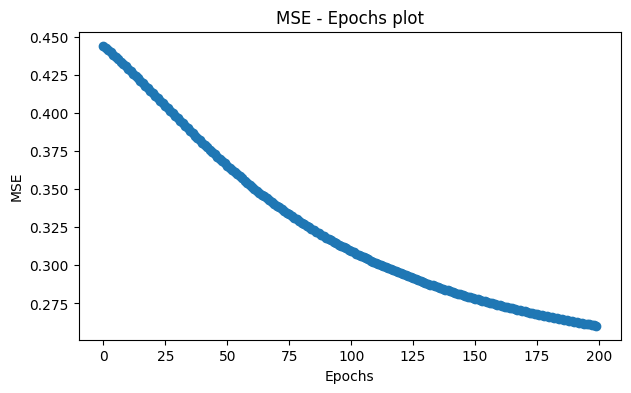

In [91]:
# plot the rmse vs epoch
def plot_rmse_epoch(train_error):
    x = range(len(train_error))
    y = train_error

    # graph
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))
    ax1.scatter(x, y)
    ax1.set_title('MSE - Epochs plot')
    ax1.set(xlabel='Epochs', ylabel='MSE')

    # the final mse
    final_mse = min(train_error)
    print(f'The Final MSE = {final_mse}')
    return final_mse


# plot
final_mse=plot_rmse_epoch(train_error)

# Prediction Result in Complete Matrix

In [93]:
# display the prediction matrix result
def pred_result():
  prediction_matrix=predictions(P,Q)
  prediction_matrix_df=matrix_df.copy()
  prediction_matrix_df[:]=prediction_matrix
  # combine the prediction and original matrix (replace the prediction rate with some existing rate )
  for row,col in zip(users, items):
    prediction_matrix_df.iloc[row,col]=matrix[row,col]
  return prediction_matrix_df

In [94]:
# The Prediction matrix result
prediction_matrix_df=pred_result()
prediction_matrix_df

,1,110,2571,260,2959,296,318,356,480,527,589,593
userId,,,,,,,,,,,,
1,4.000000,4.000000,5.000000,5.000000,5.000000,3.000000,4.585058,4.000000,4.000000,5.000000,4.130600,4.000000
10,0.708323,1.396386,0.500000,2.116499,0.500000,1.000000,1.817598,3.500000,2.241212,2.412559,1.073377,1.561221
100,3.316726,3.588359,3.788613,3.713760,3.786104,3.500000,3.955134,4.000000,3.313269,3.908535,3.416305,3.615117
101,4.193835,4.584914,4.874739,4.557193,5.000000,4.466416,5.013276,4.703920,4.079850,4.937264,4.348100,4.448504
102,3.881962,3.852882,4.202434,4.020264,4.554208,5.000000,4.000000,5.000000,3.000000,4.482532,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.071210,4.248008,5.000000,5.000000,4.297798,4.247364,4.316780,3.866050,3.500000,3.896597,4.000000,4.298106
96,5.000000,5.000000,4.000000,5.000000,4.816955,5.000000,5.010537,4.676766,5.000000,5.000000,5.000000,5.023558
97,4.419191,4.532046,5.000000,5.040508,4.847032,4.883049,4.991410,4.630501,4.386220,4.812340,4.430991,5.000000


# For Specific User_id, Generate Movie Rate Prediction

Please enter the User ID you'd like to predict: 3


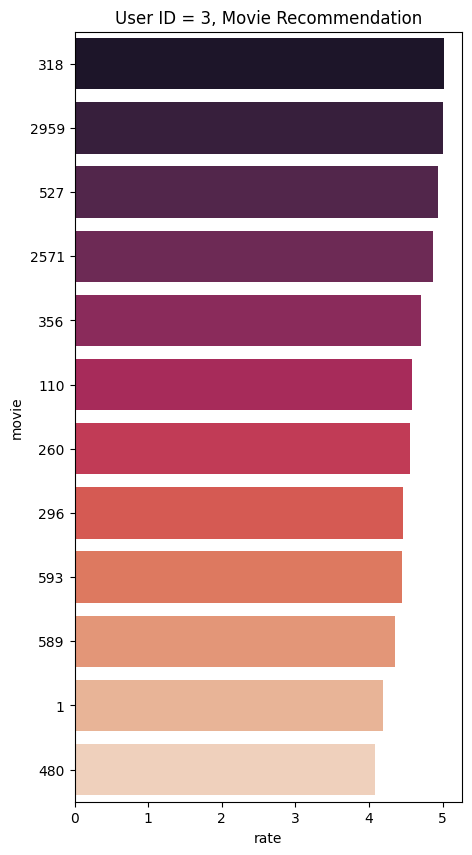

In [96]:
def recommend_by_user(user_id):
    # Check if user_id is within the valid range
    if user_id < 0 or user_id >= len(prediction_matrix_df):
        print(f"Invalid user_id: {user_id}. Please provide a valid user_id.")
        return None

    user_rate = prediction_matrix_df.iloc[user_id, :].to_frame(name='rate')
    user_rate['movie'] = user_rate.index
    user_rate.sort_values(by=['rate'], ascending=False, inplace=True)
    user_rate.reset_index(drop=True, inplace=True)

    # plot
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 10))
    sns.barplot(data=user_rate, y='movie', x='rate', palette="rocket", ax=ax1)
    ax1.set_title(f'User ID = {user_id}, Movie Recommendation')
    return user_rate

# Example usage:
# Assuming prediction_matrix_df is your DataFrame
user_id = int(input("Please enter the User ID you'd like to predict: "))
user_rate = recommend_by_user(user_id)
